In [1]:
#loading python require packages
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.models import model_from_json
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans
from sklearn.svm import OneClassSVM
import keras
from keras import layers
from IPython.display import display
from sklearn.metrics import f1_score, make_scorer
import os
from keras.utils.np_utils import to_categorical
from keras.layers import  MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D
from keras.models import Sequential
from sklearn.metrics import confusion_matrix
import seaborn as sns

Using TensorFlow backend.
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

In [2]:
#dataset loading
dataset = pd.read_csv("Dataset/Fault_data.csv")
display(dataset)

,Flow_Rate,Nozzle_Temperature,Suction_Pressure,Discharge_Power,Flow_Temperature,Anomaly
0,5.550695,3.915708,2.954724,3.101977,0.0,0
1,6.204721,3.743655,3.266856,3.577366,0.0,0
2,5.112671,4.248774,3.006690,2.940574,0.0,0
3,5.795922,4.159701,3.154457,3.352785,0.0,0
4,6.106459,4.168643,3.314856,3.712539,0.0,0
...,...,...,...,...,...,...
2004,5.269118,5.057932,4.166866,5.026991,90.0,1
2005,4.597010,4.576745,3.743260,4.538569,90.0,1
2006,5.103344,4.857237,4.164715,5.288770,90.0,1
2007,5.485759,4.998180,4.260211,5.058880,90.0,1


In [3]:
#dataset preprocessing and normalization
minmax = MinMaxScaler(feature_range = (0, 1))
dataset.fillna(0, inplace = True) #processing dataset to replace missing values with 0
data = dataset.values
X = data[:,0:dataset.shape[1]-1] #selecting features from dataset
X = minmax.fit_transform(X) #normalizing features using minmax
indices = np.arange(X.shape[0])
np.random.shuffle(indices) #shuffling the dataset
X = X[indices]
print()
print("Dataset Processing & Normalization Completed")
print()
display(X)


Dataset Processing & Normalization Completed



array([[0.13624491, 0.27284839, 0.25403853, 0.22786311, 0.22222222],
       [0.4286335 , 0.30409432, 0.29075031, 0.29720316, 0.        ],
       [0.3717771 , 0.24868475, 0.22181784, 0.19375658, 0.11111111],
       ...,
       [0.15993545, 0.33533987, 0.42402312, 0.47616405, 0.44444444],
       [0.32439535, 0.53163447, 0.5946158 , 0.80435914, 0.66666667],
       [0.12310819, 0.21665576, 0.37948021, 0.45296433, 0.33333333]])

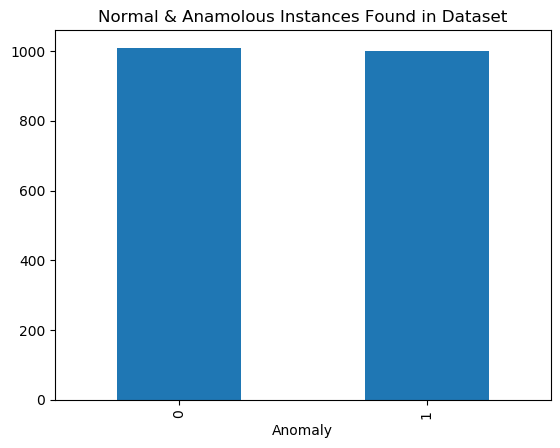

In [4]:
label = dataset.groupby('Anomaly').size()
label.plot(kind="bar")
plt.title("Normal & Anamolous Instances Found in Dataset")
plt.show()

In [5]:
print("Dataset dimension before applying PCA : "+str(X.shape[1]))
pca = PCA(n_components=4)
X = pca.fit_transform(X)
print("Dataset dimension after applying PCA : "+str(X.shape[1]))

Dataset dimension before applying PCA : 5
Dataset dimension after applying PCA : 4


Cluster Labels : [1 1 1 ... 1 0 1]
Normal & Anomaly labels calculated using KMEANS
Normal Records : 1085
Anomaly Records : 924


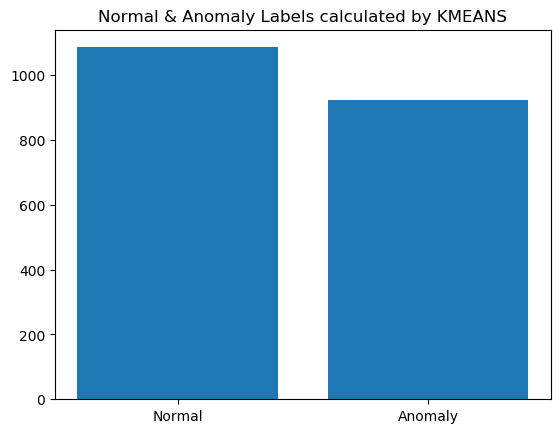

In [6]:
#applying kmeans to get normal and anomaly label
kmeans = KMeans(n_clusters=2, n_init=150, random_state=1)
kmeans.fit(X)
cluster_labels = kmeans.labels_
print("Cluster Labels : "+str(cluster_labels))
label, count = np.unique(cluster_labels, return_counts=True)
print("Normal & Anomaly labels calculated using KMEANS")
print("Normal Records : "+str(count[0]))
print("Anomaly Records : "+str(count[1]))
height = count
bars = ('Normal', 'Anomaly')
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.title("Normal & Anomaly Labels calculated by KMEANS")
plt.show()

In [7]:
#train & tes split
X_train, X_test, y_train, y_test = train_test_split(X, cluster_labels, test_size=0.1, random_state=0)
print("Total dataset size : "+str(X.shape[0]))
print("80% Training dataset : "+str(X_train.shape[0]))
print("20% Testing dataset : "+str(X_test.shape[0]))

Total dataset size : 2009
80% Training dataset : 1808
20% Testing dataset : 201


In [8]:
#function to calculate confusion matrix
def confusionMatrix(predict, test_label, algorithm):
    conf_matrix = confusion_matrix(test_label, predict) 
    labels = ["Normal", "Anomaly"]
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(labels)])
    plt.title(algorithm+" Confusion matrix") 
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()


LOF best Hyper Parameters
{'lof__contamination': 0.01, 'lof__n_neighbors': 10}

LOF Training F1 Score   : 0.4596238938053097
LOF Validation F1 Score : 0.43283582089552236


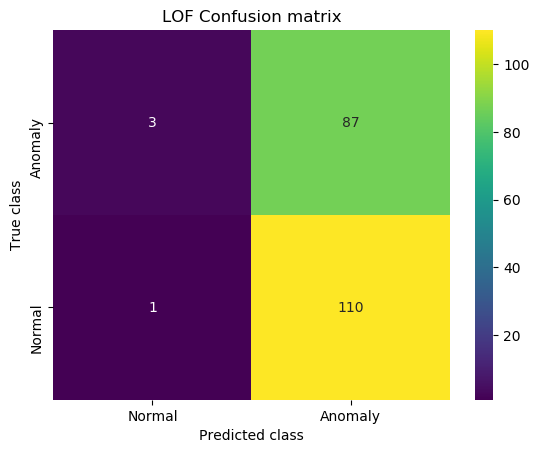

In [9]:
#defining hyper parameters for Local outlier algorithm
lof_pipe = Pipeline([('lof', LocalOutlierFactor(novelty=True))])

params = [{'lof__n_neighbors': [5, 10, 20, 30, 40],
           'lof__contamination': [0.01, 0.015, 0.02, 0.025, 0.03]}]
         
gs_lof = GridSearchCV(lof_pipe, param_grid=params, scoring = make_scorer(f1_score, average='micro'), cv=10)#train grid algorithm
gs_lof.fit(X_train, y_train)
print()
print("LOF best Hyper Parameters")
print(gs_lof.best_params_)
lof_training_score = gs_lof.score(X_train, y_train)#calculate training and validation fscore
lof_validation_score = gs_lof.score(X_test, y_test)
print()
print("LOF Training F1 Score   : "+str(lof_training_score))
print("LOF Validation F1 Score : "+str(lof_validation_score))
predict = gs_lof.predict(X_test)
predict[predict < 0] = 0
confusionMatrix(predict, y_test, "LOF")


Best Hyper Parameters
{'ocs__gamma': 0.001, 'ocs__kernel': 'rbf', 'ocs__nu': 0.015}

OCS Training F1 Score   : 0.4529867256637169
OCS Validation F1 Score : 0.44776119402985076


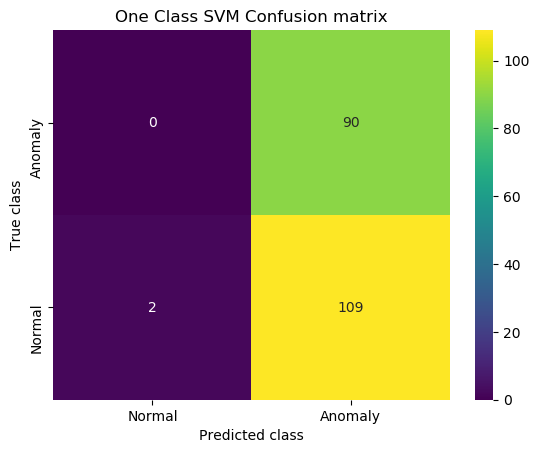

In [10]:
#defining hyper parameters fro one class svm
ocs_pipe = Pipeline([('ocs', OneClassSVM())])
params = {'ocs__kernel': ('linear', 'poly', 'rbf'), 
          'ocs__gamma': (0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.5, 0.6, 0.7, 0.8, 0.9 ,1),
          'ocs__nu': (0.015, 0.025, 0.035, 0.045)
         }
#train Grid algortihm using one class svm     
gs_ocs = GridSearchCV(ocs_pipe, param_grid=params, scoring = make_scorer(f1_score, average='micro'), cv=10)
gs_ocs.fit(X, cluster_labels)
print()
print("Best Hyper Parameters")
print(gs_ocs.best_params_)
ocs_training_score = gs_ocs.score(X_train, y_train)
ocs_validation_score = gs_ocs.score(X_test, y_test)
print()
print("OCS Training F1 Score   : "+str(ocs_training_score))
print("OCS Validation F1 Score : "+str(ocs_validation_score))
predict = gs_ocs.predict(X_test)
predict[predict < 0] = 0
confusionMatrix(predict, y_test, "One Class SVM")



Autoencoder Training F1 Score   : 53.76106194690266
Autoencoder Validation F1 Score : 55.223880597014926


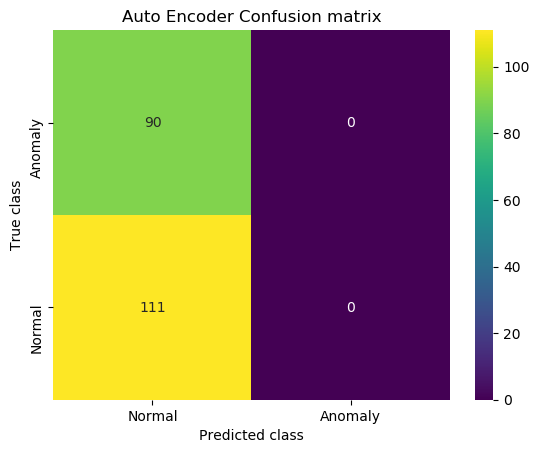

In [11]:
y_train1 = to_categorical(y_train)
y_test1 = to_categorical(y_test)
if os.path.exists('model/encoder_model.json'):
    with open('model/encoder_model.json', "r") as json_file:
        loaded_model_json = json_file.read()
        autoencoder = model_from_json(loaded_model_json)
    json_file.close()    
    autoencoder.load_weights("model/encoder_model_weights.h5")
    autoencoder._make_predict_function()  
else:
    encoding_dim = 5 # encoding dimension is 32 which means each record will be filtered 32 times to get important features from images
    input_size = keras.Input(shape=(X.shape[1],)) #we are taking input size
    encoded = layers.Dense(encoding_dim, activation='relu')(input_size) #creating dense layer to start filtering dataset with given 32 filter dimension
    decoded = layers.Dense(y_train1.shape[1], activation='softmax')(encoded) #creating another layer with input size as 784 for encoding
    autoencoder = keras.Model(input_size, decoded) #creating decoded layer to get prediction result
    encoder = keras.Model(input_size, encoded)#creating encoder object with encoded and input images
    encoded_input = keras.Input(shape=(encoding_dim,))#creating another layer for same input dimension
    decoder_layer = autoencoder.layers[-1] #holding last layer
    decoder = keras.Model(encoded_input, decoder_layer(encoded_input))#merging last layer with encoded input layer
    autoencoder.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])#compiling model
    hist = autoencoder.fit(X_train, y_train1, epochs=15, batch_size=40, shuffle=True, validation_data=(X_test, y_test1))#now start generating model with given Xtrain as input 
    autoencoder.save_weights('model/encoder_model_weights.h5')#above line for creating model will take 100 iterations            
    model_json = autoencoder.to_json() #saving model
    with open("model/encoder_model.json", "w") as json_file:
        json_file.write(model_json)
    json_file.close()
predict = autoencoder.predict(X_train) 
predict = np.argmax(predict, axis=1)
ae_training_score = f1_score(y_train, predict,average='micro') * 100
predict = autoencoder.predict(X_test) 
predict = np.argmax(predict, axis=1)
ae_validation_score = f1_score(y_test, predict,average='micro') * 100
print()
print("Autoencoder Training F1 Score   : "+str(ae_training_score))
print("Autoencoder Validation F1 Score : "+str(ae_validation_score))
confusionMatrix(predict, y_test, "Auto Encoder")


Hybrid Model Training F1 Score   : 98.94911504424779
Hybrid Model Validation F1 Score : 99.00497512437812


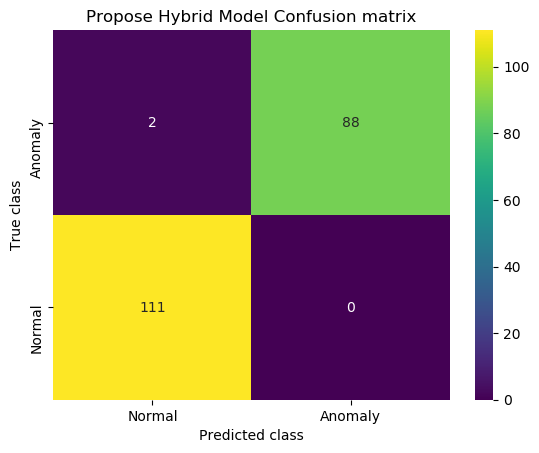

In [12]:
#ensemble model by extracting label from LOF, One class SVM and Auto encoder
lof_predict = gs_lof.predict(X)
ocs_predict = gs_ocs.predict(X)
ae_predict = autoencoder.predict(X)
ae_predict = np.argmax(ae_predict, axis=1)
hybrid_label = []
#get max satisfying label from all 3 models
for i in range(len(lof_predict)):
    counts = np.bincount(np.asarray([abs(lof_predict[i]), abs(ocs_predict[i]), abs(ae_predict[i])]))
    label = np.argmax(counts)
    if label == cluster_labels[i]:
        hybrid_label.append(label)
    else:
        hybrid_label.append(cluster_labels[i])
hybrid_label = np.asarray(hybrid_label)
hybrid_label = to_categorical(hybrid_label)
#split hybrid data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, hybrid_label, test_size=0.1, random_state=0)
#now train hybrid model by using predicted values from all 3 models 
if os.path.exists('model/hybrid_model.json'):
    with open('model/hybrid_model.json', "r") as json_file:
        loaded_model_json = json_file.read()
        hybrid_model = model_from_json(loaded_model_json)
    json_file.close()    
    hybrid_model.load_weights("model/hybrid_model_weights.h5")
    hybrid_model._make_predict_function()  
else:
    encoding_dim = 5 # encoding dimesnion is 32 which means each record will be filtered 32 times to get important features from images
    input_size = keras.Input(shape=(X_train.shape[1],)) #we are taking input size
    encoded = layers.Dense(encoding_dim, activation='relu')(input_size) #creating dense layer to start filtering dataset with given 32 filter dimension
    decoded = layers.Dense(y_train.shape[1], activation='softmax')(encoded) #creating another layer with input size as 784 for encoding
    hybrid_model = keras.Model(input_size, decoded) #creating decoded layer to get prediction result
    encoder = keras.Model(input_size, encoded)#creating encoder object with encoded input features
    encoded_input = keras.Input(shape=(encoding_dim,))#creating another layer for same input dimension
    decoder_layer = autoencoder.layers[-1] #holding last layer
    decoder = keras.Model(encoded_input, decoder_layer(encoded_input))#merging last layer with encoded input layer
    hybrid_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])#compiling model
    hist = hybrid_model.fit(X_train, y_train, epochs=15, batch_size=40, shuffle=True, validation_data=(X_test, y_test))#now start generating model with given Xtrain as input 
    hybrid_model.save_weights('model/hybrid_model_weights.h5')#above line for creating model will take 100 iterations            
    model_json = hybrid_model.to_json() #saving model
    with open("model/hybrid_model.json", "w") as json_file:
        json_file.write(model_json)
    json_file.close()
predict = hybrid_model.predict(X_train) 
predict = np.argmax(predict, axis=1)
hybrid_training_score = f1_score(np.argmax(y_train, axis=1), predict,average='micro') * 100
predict = hybrid_model.predict(X_test) 
predict = np.argmax(predict, axis=1)
hybrid_validation_score = f1_score(np.argmax(y_test, axis=1), predict,average='micro') * 100
print()
print("Hybrid Model Training F1 Score   : "+str(hybrid_training_score))
print("Hybrid Model Validation F1 Score : "+str(hybrid_validation_score))
confusionMatrix(predict, np.argmax(y_test, axis=1), "Propose Hybrid Model")



Extension CNN Model Training F1 Score   : 99.88938053097345
Extension CNN Model Validation F1 Score : 100.0


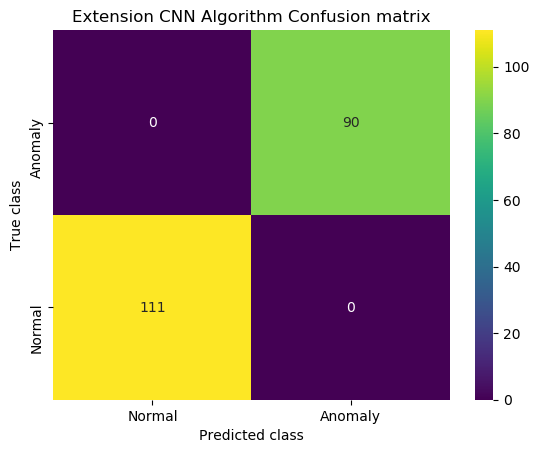

In [13]:
#extension with deep learning Convolution neural networks (CNN)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1, 1) #CNN algorithm accept input as 4 dimensional so converting data into 4 dimension
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1, 1)
if os.path.exists('model/extension_model.json'):
    with open('model/extension_model.json', "r") as json_file:
        loaded_model_json = json_file.read()
        extension_model = model_from_json(loaded_model_json)
    json_file.close()    
    extension_model.load_weights("model/extension_model_weights.h5")
    extension_model._make_predict_function()       
else:
    extension_model = Sequential()
    extension_model.add(Convolution2D(32, 1, 1, input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation = 'relu'))
    extension_model.add(MaxPooling2D(pool_size = (1, 1)))
    extension_model.add(Convolution2D(32, 1, 1, activation = 'relu'))
    extension_model.add(MaxPooling2D(pool_size = (1, 1)))
    extension_model.add(Flatten())
    extension_model.add(Dense(output_dim = 256, activation = 'relu'))
    extension_model.add(Dense(output_dim = y_train.shape[1], activation = 'softmax'))
    extension_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    hist = extension_model.fit(X_train, y_train, batch_size=40, epochs=15, shuffle=True, verbose=2, validation_data=(X_test, y_test))
    extension_model.save_weights('model/extension_model_weights.h5')            
    model_json = extension_model.to_json()
    with open("model/extension_model.json", "w") as json_file:
        json_file.write(model_json)
    json_file.close()
predict = extension_model.predict(X_train) 
predict = np.argmax(predict, axis=1)
extension_training_score = f1_score(np.argmax(y_train, axis=1), predict,average='micro') * 100
predict = extension_model.predict(X_test) 
predict = np.argmax(predict, axis=1)
extension_validation_score = f1_score(np.argmax(y_test, axis=1), predict,average='micro') * 100
print()
print("Extension CNN Model Training F1 Score   : "+str(extension_training_score))
print("Extension CNN Model Validation F1 Score : "+str(extension_validation_score))    
confusionMatrix(predict, np.argmax(y_test, axis=1), "Extension CNN Algorithm")    
    

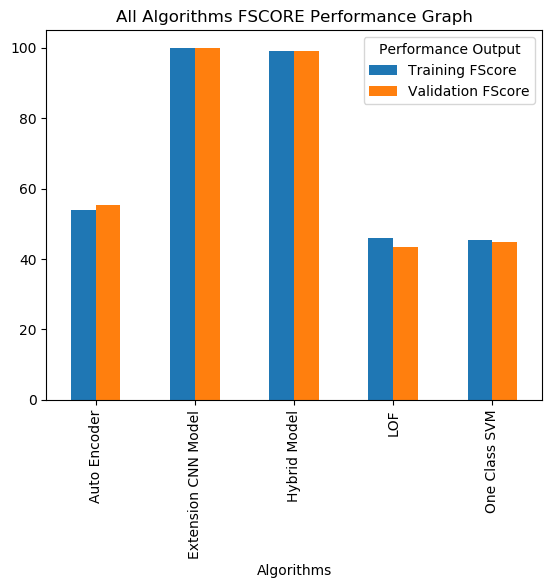

In [14]:
#performance graph and tabular output
df = pd.DataFrame([['LOF','Training FScore',lof_training_score*100],['LOF','Validation FScore',lof_validation_score*100],
                   ['One Class SVM','Training FScore',ocs_training_score*100],['One Class SVM','Validation FScore',ocs_validation_score*100],
                   ['Auto Encoder','Training FScore',ae_training_score],['Auto Encoder','Validation FScore',ae_validation_score],
                   ['Hybrid Model','Training FScore',hybrid_training_score],['Hybrid Model','Validation FScore',hybrid_validation_score],
                   ['Extension CNN Model','Training FScore',extension_training_score],['Extension CNN Model','Validation FScore',extension_validation_score],
                  ],columns=['Algorithms','Performance Output','Value'])
df.pivot("Algorithms", "Performance Output", "Value").plot(kind='bar')
plt.rcParams["figure.figsize"]= [8,5]
plt.title("All Algorithms FSCORE Performance Graph")
plt.show()



In [15]:
#display all algorithm FSCORES in tabular format
columns = ["Algorithm Name","Training FScore", "Validation FScore"]
values = []
algorithm_names = ["LOF", "One Class SVM", "Auto Encoder", "Hybrid Ensemble Model", "Extension CNN Model"]
values.append([algorithm_names[0],lof_training_score, lof_validation_score])
values.append([algorithm_names[1],ocs_training_score, ocs_validation_score])
values.append([algorithm_names[2],ae_training_score, ae_validation_score])
values.append([algorithm_names[3],hybrid_training_score, hybrid_validation_score])
values.append([algorithm_names[4],extension_training_score, extension_validation_score])
    
temp = pd.DataFrame(values,columns=columns)
display(temp)

,Algorithm Name,Training FScore,Validation FScore
0,LOF,0.459624,0.432836
1,One Class SVM,0.452987,0.447761
2,Auto Encoder,53.761062,55.223881
3,Hybrid Ensemble Model,98.949115,99.004975
4,Extension CNN Model,99.889381,100.000000
